<a href="https://colab.research.google.com/github/NLPetroni/assignment_two/blob/main/solution_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and downloads



In [1]:
import random

import numpy as np
import pandas as pd
import sys
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if not os.path.isdir('res'):
    os.mkdir('res')

if IN_COLAB:
  %cd /content
  !rm -rf assignment_two &> /dev/null
  !git clone https://github.com/NLPetroni/assignment_two &> /dev/null
  %cd assignment_two
  sys.path.append(os.getcwd())
  !git clone https://gitlab.com/sasso-effe/nlp-assignment-data.git &> /dev/null
  !mv nlp-assignment-data/embedding_matrix.npy res/embedding_matrix.npy
  !rm -rf nlp-assignment-data
  !pip install wandb &> /dev/null
  !pip install torchinfo &> /dev/null

/content
/content/assignment_two


In [2]:
import re
import math
from functools import reduce
from typing import List, Callable
import pickle

import wandb
import nltk
from nltk.corpus import stopwords
import torch
from torch import nn
from torchinfo import summary
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from src import utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def explore():
    utils.download_data('dataset')
    train_set = pd.read_csv("dataset/train_pairs.csv")
    val_set = pd.read_csv("dataset/val_pairs.csv")
    test_set = pd.read_csv("dataset/test_pairs.csv")

    print(train_set.columns)
    print("Total rows of the train set: {:d}".format(len(train_set)))
    print("Total rows of the validation set: {:d}".format(len(val_set)))
    print("Total rows of the test set: {:d}".format(len(test_set)))
    print(train_set['Label'].value_counts())
explore()

Download completed!
Extracting dataset...
Extraction completed!
Index(['Unnamed: 0', 'Claim', 'Evidence', 'ID', 'Label'], dtype='object')
Total rows of the train set: 121740
Total rows of the validation set: 7165
Total rows of the test set: 7189
SUPPORTS    89389
REFUTES     32351
Name: Label, dtype: int64


# Dataset pre-processing and conversion

In [4]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;\t-]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
BAD_SYMBOLS_RE = re.compile('(-LRB-)|(-RRB-)|(-LSB-)|(-RSB-)')
INSIDE_SQAURE_BRACKETS_RE = re.compile('(-LSB-).*?(-RSB-)')

try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

def remove_inside_square_brackets(text: str) -> str:
    return INSIDE_SQAURE_BRACKETS_RE.sub('', text)

def remove_bad_symbols(text: str) -> str:
    return BAD_SYMBOLS_RE.sub('', text)

def remove_final_tags(text: str) -> str:
   return re.sub('\.\t.*?$', '', text) 

def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def replace_br(text: str) -> str:
    """
    Replaces br characters
    """

    return text.replace('</br>', '')

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])


def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()

def split_text(text: str) -> List:
  return text.split()

PREPROCESSING_PIPELINE = [
                          remove_inside_square_brackets,
                          remove_bad_symbols,
                          lower,
                          remove_final_tags,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          strip_text,
                          split_text
                          ]

# Anchor method

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), filter_methods, text)

def full_preprocessing(dataset):
    # In the evidences there is an id at the beginning of the sequence which is
    # removed with the splice [:1]
    dataset['Evidence'] = dataset['Evidence'].apply(lambda txt: text_prepare(txt)[1:])
    dataset['Claim'] = dataset['Claim'].apply(lambda txt: text_prepare(txt))
    return dataset


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Padding

In [5]:
class Dataset(torch.utils.data.Dataset):
    """Simple dataset class to use dataloaders (batching) """
    def __init__(self, ids, claims, evidences, labels, majority_vote=False):
        self.majority_vote = majority_vote
        if self.majority_vote:
            self.ids = ids
            self.indexes = list(set(self.ids))
            self.majority_data = [[(claims[i], evidences[i], labels[i]) for i, id in enumerate(self.ids) if id == idx]
                                  for idx in self.indexes]
        else:
            self.claims = claims
            self.evidences = evidences
            self.labels = torch.tensor(labels, dtype=torch.float)

    def __getitem__(self, idx):
        if self.majority_vote:
          item = self.majority_data[idx]
        else:
          item = self.claims[idx], self.evidences[idx], self.labels[idx]        
        return item
    def __len__(self):
        return len(self.indexes) if self.majority_vote else self.claims.shape[0]

In [6]:
def to_tensor_collate(batch):
    claims, evidences, labels = zip(*batch)
    return torch.as_tensor(claims), None,  torch.as_tensor(evidences), None, torch.as_tensor(labels)


def pad_batch_collate(batch):
    """Used by DataLoader to pad each batch independently"""
    claims, evidences, targets = zip(*batch)

    claims_lens = torch.as_tensor([len(seq) for seq in claims])
    padded_claims = torch.nn.utils.rnn.pad_sequence([torch.as_tensor(seq) for seq in claims], 
                                                    batch_first=True, padding_value=utils.PAD_TOKEN)
    evidences_lens = torch.as_tensor([len(seq) for seq in evidences])
    padded_evidences = torch.nn.utils.rnn.pad_sequence([torch.as_tensor(seq) for seq in evidences], 
                                                    batch_first=True, padding_value=utils.PAD_TOKEN)
    targets = torch.as_tensor(targets)

    return padded_claims, claims_lens, padded_evidences, evidences_lens, targets


def pad_vote_collate(batch):
    """
    Collate function for the dataloader, used for majority voting evaluation.
    Returns:
        A list of batches, where each batch contains all the pairs claim-evidence for a single claim.
        The list is unpacked in the evaluation method and passed batch-by-batch to the model.
    """
    batch_res = []
    
    for elem in batch:
        claims, evidences, targets = zip(*elem)
        claims_lens = torch.as_tensor([len(seq) for seq in claims])
        padded_claims = torch.nn.utils.rnn.pad_sequence([torch.as_tensor(seq) for seq in claims], 
                                                         batch_first=True, padding_value=utils.PAD_TOKEN)
        evidences_lens = torch.as_tensor([len(seq) for seq in evidences])
        padded_evidences = torch.nn.utils.rnn.pad_sequence([torch.as_tensor(seq) for seq in evidences], 
                                                            batch_first=True, padding_value=utils.PAD_TOKEN)
        targets = torch.as_tensor(targets)
        batch_res.append([padded_claims, claims_lens, padded_evidences, evidences_lens, targets])

    return batch_res

## Glove

In [19]:
def __generate_voc_and_matrix(train_set, val_set, test_set):
  voc_evidence_train = [item for sublist in train_set['Evidence'] for item in sublist]
  voc_claim_train = [item for sublist in train_set['Claim'] for item in sublist]
  TRAIN_VOC = set(voc_evidence_train + voc_claim_train)
  voc_evidence_val = [item for sublist in val_set['Evidence'] for item in sublist]
  voc_claim_val = [item for sublist in val_set['Claim'] for item in sublist]
  VAL_VOC = set(voc_evidence_val + voc_claim_val)
  voc_evidence_test = [item for sublist in test_set['Evidence'] for item in sublist]
  voc_claim_test = [item for sublist in test_set['Claim'] for item in sublist]
  TEST_VOC = set(voc_evidence_test + voc_claim_test)

  inputs = train_set['Evidence'].tolist() + train_set['Claim'].tolist()
  glove_voc, embedding_matrix = utils.get_glove(number_token=False)
  vocabulary, embedding_matrix = utils.add_oov(glove_voc, TRAIN_VOC, embedding_matrix, inputs)
  inputs = val_set['Evidence'].tolist() + val_set['Claim'].tolist()
  vocabulary, embedding_matrix = utils.add_oov(vocabulary, VAL_VOC, embedding_matrix, inputs)
  inputs = test_set['Evidence'].tolist() + test_set['Claim'].tolist()
  vocabulary, embedding_matrix = utils.add_oov(vocabulary, TEST_VOC, embedding_matrix, inputs)

  with open("res/vocabulary.pkl", "wb") as file:
    pickle.dump(vocabulary, file)
  np.save("res/embedding_matrix.npy", embedding_matrix)
  return vocabulary, embedding_matrix


def get_voc_and_matrix(train_set, val_set, test_set):
    if os.path.exists("res/vocabulary.pkl"):
      print('The vocabulary is already present. Loading it...', end=' ')
      with open('res/vocabulary.pkl', 'rb') as f:
        vocabulary = pickle.load(f)
      print('Done!')
      if os.path.exists("res/embedding_matrix.npy"):
        print('The embedding matrix is already present. Loading it...', end=' ')
        embedding_matrix = np.load("res/embedding_matrix.npy", )
        print("Done!")
      else:
        print('The embedding matrix is NOT present. You can download it from https://gitlab.com/sasso-effe/nlp-assignment-data and put it in the res folder. Alternatively you can generate a new embedding matrix, but the process is very long.\n')
        answer = input('Do you want to generate a new embedding matrix (and a new vocabulary)? (Y/n)')
        answer = answer in ['Y', 'y', 'yes', 'Yes']
        if answer:
          vocabulary, embedding_matrix = __generate_voc_and_matrix(train_set, val_set, test_set)
          print("Vocabulary and embedding matrix created! Remember to download the generated files if you are on Colab.")
        else:
          raise Exception('Downaload the embedding matrix from https://gitlab.com/sasso-effe/nlp-assignment-data and rerun this cell')
    else:
      print("The vocabulary and the embedding matrix are NOT present. Creating them...")
      vocabulary, embedding_matrix = __generate_voc_and_matrix(train_set, val_set, test_set)
      print("Vocabulary and embedding matrix created! Remember to download the generated files if you are on Colab.")
    return vocabulary, embedding_matrix


## Tokenization

In [8]:
def tokenize(input: List, vocabulary) -> torch.Tensor:
  result = list(map(lambda x: vocabulary[x], input))
  return result

def detokenize(input: torch.Tensor, inverse_vocabulary) -> List:
  result = input.tolist()
  # FIXME sistemare computazione
  result = list(map(lambda x: inverse_vocabulary[x], result))
  return result

def full_tokenization(data, vocabulary):
    data['Evidence'] = data['Evidence'].map(lambda x: tokenize(x, vocabulary))
    data['Claim'] = data['Claim'].map(lambda x: tokenize(x, vocabulary))
    data['Label'] = data['Label'].map(lambda x: float(1.0) if x == 'SUPPORTS' else float(0.0))
    return data

# Putting everything together

In [9]:
def load_data(padding=False):
    utils.download_data('dataset')
    train_set = pd.read_csv("dataset/train_pairs.csv")
    val_set = pd.read_csv("dataset/val_pairs.csv")
    test_set = pd.read_csv("dataset/test_pairs.csv")

    # preprocessing
    train_set = full_preprocessing(train_set)
    val_set = full_preprocessing(val_set)
    test_set = full_preprocessing(test_set)

    if padding:
        evidence_lens = [len(te) for te in train_set['Evidence']] + [len(ve) for ve in val_set['Evidence']] + [len(te) for te in test_set['Evidence']]
        max_evidence_len = np.quantile(evidence_lens, 0.99, interpolation='nearest')

        claim_lens = [len(te) for te in train_set['Claim']] + [len(ve) for ve in val_set['Claim']] + [len(te) for te in test_set['Claim']]
        max_claim_len = np.quantile(claim_lens, 0.99, interpolation='nearest')

        tr_ev_lens = train_set['Evidence'].map(lambda e: len(e))
        tr_claim_lens = train_set['Claim'].map(lambda c: len(c))
        train_set = train_set.drop(train_set[(tr_ev_lens >= max_evidence_len) | (tr_claim_lens >= max_claim_len)].index).reset_index()
        va_ev_lens = val_set['Evidence'].map(lambda e: len(e))
        va_claim_lens = val_set['Claim'].map(lambda c: len(c))
        val_set = val_set.drop(val_set[(va_ev_lens >= max_evidence_len) | (va_claim_lens >= max_claim_len)].index).reset_index()
        te_ev_lens = test_set['Evidence'].map(lambda e: len(e))
        te_claim_lens = test_set['Claim'].map(lambda c: len(c))
        test_set = test_set.drop(test_set[(te_ev_lens >= max_evidence_len) | (te_claim_lens >= max_claim_len)].index).reset_index()

        train_set.loc[:, 'Evidence'] = train_set['Evidence'].map(lambda x: x + (['<PAD>'] * (max_evidence_len - len(x))))
        val_set.loc[:, 'Evidence'] = val_set['Evidence'].map(lambda x: x + (['<PAD>'] * (max_evidence_len - len(x))))
        test_set.loc[:, 'Evidence'] = test_set['Evidence'].map(lambda x: x + (['<PAD>'] * (max_evidence_len - len(x))))

        train_set.loc[:, 'Claim'] = train_set['Claim'].map(lambda x: x + (['<PAD>'] * (max_claim_len - len(x))))
        val_set.loc[:, 'Claim'] = val_set['Claim'].map(lambda x: x + (['<PAD>'] * (max_claim_len - len(x))))
        test_set.loc[:, 'Claim'] = test_set['Claim'].map(lambda x: x + (['<PAD>'] * (max_claim_len - len(x))))


    vocabulary, embedding_matrix = get_voc_and_matrix(train_set, val_set, test_set)

    # tokenization
    train_set = full_tokenization(train_set, vocabulary)
    val_set = full_tokenization(val_set, vocabulary)
    test_set = full_tokenization(test_set, vocabulary)

    return vocabulary, embedding_matrix, (train_set, val_set, test_set)

# Model definition

In [10]:
# lambda layers

class LambdaLast(torch.nn.Module):
    def forward(self, x, h_n):
        # assuming bidirectional rnn, taking concatenation of last hidden states (of the last layer)
        return torch.cat((h_n[-1], h_n[-2]), dim=1)

class LambdaAvg(torch.nn.Module):
  def forward(self, x, h_n):
    # average of all the output features
    return torch.mean(x, dim=1)

class LambdaConcatenation(torch.nn.Module):
  def forward(self, x, y):
    return torch.cat((x, y), dim=1)

class LambdaSum(torch.nn.Module):
  def forward(self, x, y):
    return x + y

class LambdaMean(torch.nn.Module):
  def forward(self, x, y):
    return (x + y) / 2


In [11]:
def get_binary_classifier(name:str, w_in: int, w_hidden: int, n_layers=2) -> nn.Sequential:
    """Gets a sequential container with a linear+relu+linear classifier

    Args:
        name: the name prefix to append to each layer in the container.
        w_in: the number of the input features.
        w_hidden: the number of internal weights

    Returns: the created sequential.
    """
    assert n_layers >= 2, f'n_layers is {n_layers}, must be >= 2'
    container = nn.Sequential()
    container.add_module(f'{name}_fc1', nn.Linear(in_features=w_in, out_features=w_hidden))    
    container.add_module(f'{name}_ReLU', nn.ReLU())
    for i in range(n_layers-2):
      container.add_module(f'{name}_fc{i+2}', nn.Linear(in_features=w_hidden, out_features=w_hidden))
      container.add_module(f'{name}_ReLU', nn.ReLU())
    container.add_module(f'{name}_fc2', nn.Linear(in_features=w_hidden, out_features=1))
    return container

 
class RNNEncoder(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, rnn_type='elman', output_fn='last', verbose=False):
        super().__init__()
        if verbose:
          print('Initializing RNNEncoder ')
        types = {'elman': nn.RNN, 'lstm': nn.LSTM, 'gru': nn.GRU}
        output_layers = {'last': LambdaLast, 'avg': LambdaAvg}
        try:
          self.output_layer = output_layers[output_fn]()
        except:
          raise ValueError(f"wrong type '{output_fn}', must be in {list(output_layers.keys())}")

        try:
          rec_module = types[rnn_type]
        except:
          valid_types = list(types.keys())
          raise ValueError(f"wrong type '{rnn_type}', must be in {valid_types}")
        self.rec_module = rec_module(input_size=input_size, hidden_size=hidden_size,
                                     bidirectional=True, batch_first=True,
                                     num_layers=num_layers)

    def forward(self, x, lengths):
        x = torch.nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        x, h_n = self.rec_module(x)
        if isinstance(h_n, tuple):
            h_n, _ = h_n  # drop cell state
        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        x = self.output_layer(x, h_n)
        return x

class BagOfVectorsEncoder(torch.nn.Module):

  def __init__(self):
    super().__init__()

  def forward(self, x, lenghts):
    # TODO: check if the mean is computed on the right axis
    return torch.mean(x, dim=1)


class MLPEncoder(torch.nn.Module):

  def __init__(self, ws_in, w_out, layers=None, name='mlp'):
    super().__init__()
    self.ws_in = ws_in
    self.name = name
    self.__build_mlps(w_out, layers)

  def forward(self, x, lenghts):
    batch_size, max_tokens, embedding_dim = x.shape
    in_features = max_tokens * embedding_dim
    x = torch.reshape(x, (batch_size, in_features))
    if in_features == self.ws_in[0]:
        x = self.evidence_mlp(x)
    elif in_features == self.ws_in[1]:
        x = self.claim_mlp(x)
    else:
        raise ValueError(f'wrong input shape {x.shape}, must be in {self.ws_in}')
    return x

  def __build_mlps(self, w_out, layers):
    if layers is None:
        layers = [w_out, w_out]
    else:
        layers = [w_out] + layers

    self.evidence_mlp = nn.Sequential()
    self.evidence_mlp.add_module(f'{self.name}_fc1', nn.Linear(in_features=self.ws_in[0], out_features=layers[0]))
    for i, (w_in, w_out) in enumerate(zip(layers[:-1], layers[1:])):
      self.evidence_mlp.add_module(f'{self.name}_ReLU', nn.ReLU())
      self.evidence_mlp.add_module(f'{self.name}_fc{i+2}', nn.Linear(in_features=w_in, out_features=w_out))

    self.claim_mlp = nn.Sequential()
    self.claim_mlp.add_module(f'{self.name}_fc1', nn.Linear(in_features=self.ws_in[1], out_features=layers[0]))
    for i, (w_in, w_out) in enumerate(zip(layers[:-1], layers[1:])):
      self.claim_mlp.add_module(f'{self.name}_ReLU', nn.ReLU())
      self.claim_mlp.add_module(f'{self.name}_fc{i+2}', nn.Linear(in_features=w_in, out_features=w_out))

In [12]:
class FactChecker(torch.nn.Module):

  def __init__(self, embedding_matrix, encoder, merger, ws_in=None, rnn_type=None, rnn_output=None, rec_size=1, hid_size=50, n_layers_classifier=3, cosine_similarity=False):
    """
      A recurrent network performing Neural Language Inference (Fact Checking).
      Params:
        embedding_matrix: the embedding matrix for word embedding
        encoder: [rnn, mlp, bag], the encoder to compute the sentence embedding
        merger: [concatenation, sum, mean], the multi-input merging strategy
        n_layers_classifier: int, the number of layers in the classifier
        RNNEncoder params, only relevant if encoder==rnn:
          rnn_type: [elman, lstm, gru], the RNN architecure used in the encoder
          rnn_output: [last, avg], the function to compute the sentence encoding from the RNN hidden states
          rec_size: int, the number of layers in the rnn
          hid_size: int, the hidden size of the rnn
    """
    super().__init__()
    self.hid_size = hid_size
    self.cosine_similarity = cosine_similarity

    # Word embedding
    emb_size = embedding_matrix.shape[1]
    self.emb_layer = nn.Embedding.from_pretrained(torch.as_tensor(embedding_matrix))

    # Sentence embedding
    if encoder == 'rnn':
      self.encoder = RNNEncoder(emb_size, hid_size, rec_size, rnn_type=rnn_type, output_fn=rnn_output)
    elif encoder == 'mlp':
      self.encoder = MLPEncoder(ws_in=ws_in, w_out=100)
    elif encoder == 'bag':
      self.encoder = BagOfVectorsEncoder()
    else:
      raise ValueError(f"Wrong encoder '{encoder}', must be in ['rnn', 'mlp', 'bag']")

    # Merging
    merging_strategies = {
        'concatenation': LambdaConcatenation,
        'sum': LambdaSum,
        'mean': LambdaMean
    }
    try:
      merging_layer = merging_strategies[merger]
    except:
      valid_strategies = list(merging_strategies.keys())
      raise ValueError(f"wrong type '{merger}', must be in {valid_strategies}")
    self.merger = merging_layer()

    # Classifier
    classifier_in = self.hid_size * 2 if encoder=='rnn' else 100
    if merger == 'concatenation':
      classifier_in *= 2
    if self.cosine_similarity:
      classifier_in += 1
    self.classifier = get_binary_classifier('classifier', w_in=classifier_in, w_hidden=classifier_in//2, n_layers=n_layers_classifier)

  def forward(self, claim, claim_lengths, evidence, evidence_lengths, debug=False):
    # Word embedding
    claim = self.emb_layer(claim).float()
    evidence = self.emb_layer(evidence).float()
    if debug:
      print("After word embedding")
      print(f"\tclaim.shape: {claim.shape}")
      print(f"\tevidence.shape: {evidence.shape}")
    # Sentence embedding
    claim = self.encoder(claim, claim_lengths)
    evidence = self.encoder(evidence, evidence_lengths)
    if debug:
      print("After phrase encoding")
      print(f"\tclaim.shape: {claim.shape}")
      print(f"\tevidence.shape: {evidence.shape}")
    # Merging
    merged_data = self.merger(claim, evidence)
    if debug:
      print("After merging")
      print(f"\tmerged_data.shape: {merged_data.shape}")
    #Cosine Similarity
    if self.cosine_similarity:
      cs = torch.nn.functional.cosine_similarity(claim,evidence, dim=1)
      cs = torch.unsqueeze(cs, dim=1)
      merged_data = torch.cat((merged_data, cs), dim=1)
    # Classifying
    output = self.classifier(merged_data)

    return output

# Training

In [13]:
class EarlyStopping:
    def __init__(self, patience, model, delta=0, path='res'):
        self.patience = patience
        self.delta = delta
        self.model = model
        self.path = path
        if not os.path.isdir(self.path):
            os.mkdir(self.path)
        self.best_score = float('inf')
        self.counter = 0
    
    def step(self, epoch, score):
        """ Updates ES tracker after one epoch.
            Params:
                epoch: current epoch
                score: validation loss
            Returns tuple (stop, checkpoint), 
                where stop is True if early stopping has occurred and False otherwise,
                and checkpoint is last best checkpoint
        """
        if score < self.best_score:
            # print('Validation loss decreasing, storing new checkpoint')
            self.best_score = score
            self.counter = 0
            checkpoint = {'model': self.model.state_dict(), 'epoch': epoch}
            torch.save(checkpoint, 'res/checkpoint.pth')
            return False, checkpoint
        elif abs(score - self.best_score) > self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                print(f'Early stopping occured at epoch {epoch} with patience {self.patience}')
                checkpoint = torch.load('res/checkpoint.pth', map_location='cpu')
                return True, checkpoint
            if self.counter == (self.patience//2):
                print(f'Validation loss increasing for {self.counter} epochs')
        return False, None

In [22]:
def training_step(model, optimizer, loss_fn, data_loader, device):
  model.train()
  log_dict = {'train/loss': [], 'train/accuracy': [], 'train/precision': [], 'train/recall': [], 'train/f1': []}
  for (claims, cl_lengths, evidences, ev_lengths, labels) in data_loader:
    # forward
    claims = claims.to(device) 
    evidences = evidences.to(device)
    labels = labels.to(device)

    outputs = model(claims, cl_lengths, evidences, ev_lengths)
    outputs = outputs.view(outputs.size(0))
    loss = loss_fn(outputs, labels)
    loss_value = loss.item()

    if not math.isfinite(loss_value):
      print(f"Loss is {loss_value}, stopping training")
      exit(1)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        preds = torch.sigmoid(outputs).round()
        labels, preds = labels.cpu().numpy(), preds.cpu().numpy()
        acc = ((labels == preds).sum() / labels.size).item()
        prec = precision_score(labels, preds)
        rec = recall_score(labels, preds)
        f1 = f1_score(labels, preds)

    log_dict['train/loss'].append(loss_value)
    log_dict['train/accuracy'].append(acc)
    log_dict['train/precision'].append(prec)
    log_dict['train/recall'].append(rec)
    log_dict['train/f1'].append(f1)

  return log_dict


def evaluate(model, loss_fn, data_loader, device, split):
  """
    Evaluate model on the given dataloader.
    Parameters:
      model: torch.nn.Module to evaluate
      loss_fn: torch.nn criterion to use to compute loss, given outputs and targets
      data_loader: torch.utils.data.DataLoader
      device: torch.device where evaluation is performed
    Returns log dict {'valid/loss' : mean loss, 'valid/{metric}': mean metric}
  """
  model.eval()
  assert len(data_loader) == 1 # must be a single batch

  with torch.no_grad():
    data = next(iter(data_loader))

    # Variables for majority voting
    vote_labels = []
    vote_preds = []
    # Variable for standard
    loss_values = []
    std_labels = []
    std_preds = []
    for claims, cl_lengths, evidences, ev_lengths, labels in data:
      claims = claims.to(device)
      evidences = evidences.to(device)
      labels = labels.to(device)
      outputs = model(claims, cl_lengths, evidences, ev_lengths)
      outputs = outputs.view(outputs.size(0))
      preds = torch.sigmoid(outputs).round()
      loss_values.append(loss_fn(outputs, labels).cpu().numpy())
      labels = list(labels.cpu())
      preds = list(preds.cpu())
      # Majority voting
      true_label = np.mean(labels).round()
      predicted_label = np.mean(preds).round()
      vote_labels.append(true_label)
      vote_preds.append(predicted_label)
      # Standard
      std_labels += labels
      std_preds += preds
    # Majority voting
    vote_acc = accuracy_score(vote_labels, vote_preds)
    vote_prec = precision_score(vote_labels, vote_preds)
    vote_rec = recall_score(vote_labels, vote_preds)
    vote_f1 = f1_score(vote_labels, vote_preds)
    # Standard
    acc = accuracy_score(std_labels, std_preds)
    prec = precision_score(std_labels, std_preds)
    rec = recall_score(std_labels, std_preds)
    f1 = f1_score(std_labels, std_preds)
  log_dict = {f'{split}/loss': np.mean(np.concatenate(loss_values)),
              f'{split}/accuracy': acc,
              f'{split}/precision': prec,
              f'{split}/recall': rec,
              f'{split}/f1': f1,
              f'{split}/vote_accuracy': vote_acc,
              f'{split}/vote_precision': vote_prec,
              f'{split}/vote_recall': vote_rec,
              f'{split}/vote_f1': vote_f1}
  return log_dict

In [23]:
DEFAULT_PARAMS = {
          'encoder': 'rnn',
          'merger': 'concatenation',
          'rnn_type': 'elman',
          'rnn_output': 'last',
          'rec_size': 1,
          'hid_size': 50,
          'cosine_similarity': False
      }

def fix_random(seed):
    """ Fix all the possible sources of randomness
        Params:
            seed: the seed to use
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def train(optimizer, lr, device, n_epochs, verbose, batch_size, test=False, tags=None, seed=42, **model_params):
  fix_random(seed)
  model_params = {**DEFAULT_PARAMS, **model_params}
  cfg_dict = {'epochs': n_epochs, 'batch_size': batch_size, 'optimizer': optimizer, 'lr': lr, 'params': model_params}

  wandb.login(key=utils.get_wandbkey())
  run = wandb.init(project="assignment-two", entity="nlpetroni", reinit=True, config=cfg_dict, tags=tags)
  wandb.define_metric("train_step")
  wandb.define_metric("epoch")
  wandb.define_metric('train/loss', step_metric="train_step", summary="min")
  wandb.define_metric("train/accuracy", step_metric="train_step", summary="max")
  wandb.define_metric("valid/loss", step_metric="epoch", summary="min")
  wandb.define_metric("valid/accuracy", step_metric="epoch", summary="max")
  wandb.define_metric("valid/precision", step_metric="epoch", summary="max")
  wandb.define_metric("valid/recall", step_metric="epoch", summary="max")
  wandb.define_metric("valid/f1", step_metric="epoch", summary="max")
  wandb.define_metric("valid/vote_accuracy", step_metric="epoch", summary="max")
  wandb.define_metric("valid/vote_precision", step_metric="epoch", summary="max")
  wandb.define_metric("valid/vote_recall", step_metric="epoch", summary="max")
  wandb.define_metric("valid/vote_f1", step_metric="epoch", summary="max")

  if model_params['encoder'] == 'mlp':
      # with MLP encoder, every sequence must have the same length, thus we must pad at the dataset level
      padding = True
      collate_fn = to_tensor_collate
  else:
      # with other encoders, pad each batch independently
      padding = False
      collate_fn = pad_batch_collate

  vocabulary, embedding_matrix, dataset = load_data(padding=padding)
  train_set, valid_set, test_set = dataset
  train_ds = Dataset(train_set['ID'], train_set['Claim'], train_set['Evidence'], train_set['Label'])
  valid_ds = Dataset(valid_set['ID'], valid_set['Claim'], valid_set['Evidence'], valid_set['Label'], majority_vote=True)
  test_ds = Dataset(test_set['ID'], test_set['Claim'], test_set['Evidence'], test_set['Label'], majority_vote=True)
  train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
  valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=len(valid_ds), collate_fn=pad_vote_collate)
  test_dl = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds), collate_fn=pad_vote_collate)
  if model_params['encoder'] == 'mlp':
    model_params['ws_in'] = (len(train_set.loc[0, 'Evidence'] * embedding_matrix.shape[1]), len(train_set.loc[0, 'Claim'] * embedding_matrix.shape[1]))

  model = FactChecker(embedding_matrix, **model_params)
  model.to(device)
  wandb.watch(model, log_graph=True)
  if verbose:
    print(summary(model))

  params = [p for p in model.parameters() if p.requires_grad]
  if optimizer == 'rmsprop':
    optimizer = torch.optim.RMSprop(params, lr=lr, alpha=0.99, momentum=0.5, weight_decay=0)
  elif optimizer == 'adam':
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999), weight_decay=0)
  else:
    raise ValueError(f'wrong optim {optimizer}, either rmsprop or adam')

  loss = nn.BCEWithLogitsLoss()
  valid_loss = nn.BCEWithLogitsLoss(reduction='none')
  train_step = 0
  print('STARTING TRAINING')
  print('Evaluation metrics are computed on validation set\n')
  print(f'EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL | {"F1":^5} | V_ACC | V_PREC | V_REC | V_F1')
  es_tracker = EarlyStopping(20, model)
  epoch = 0
  early_stopped = False
  while epoch < n_epochs and not early_stopped:
    log_dict = training_step(model, optimizer, loss, train_dl, device)
    if not test:
      log_dict.update(evaluate(model, valid_loss, valid_dl, device, split='valid'))
      early_stopped, checkpoint = es_tracker.step(epoch, log_dict['valid/loss'])
      if early_stopped:
                model.load_state_dict(checkpoint['model'])
      for batch_loss, batch_acc, batch_f1 in zip(log_dict['train/loss'], log_dict['train/accuracy'], log_dict['train/f1']):
        wandb.log({'train_step': train_step, 'epoch': epoch, 'train/loss': batch_loss, 'train/accuracy': batch_acc,
                   'train/f1': batch_f1})
        train_step += 1
      wandb.log({'epoch': epoch, 'valid/loss': log_dict['valid/loss'],
                 'valid/accuracy': log_dict['valid/accuracy'],
                 'valid/precision': log_dict['valid/precision'],
                 'valid/recall': log_dict['valid/recall'],
                 'valid/f1': log_dict['valid/f1'],
                 'valid/vote_accuracy': log_dict['valid/vote_accuracy'],
                 'valid/vote_precision': log_dict['valid/vote_precision'],
                 'valid/vote_recall': log_dict['valid/vote_recall'],
                 'valid/vote_f1': log_dict['valid/vote_f1']})
      if epoch % 10 == 0:
        print(f'[{epoch:02d}/{n_epochs:02d}]| {np.mean(log_dict["train/loss"]):10.3f} | {log_dict["valid/loss"]:10.3f} | {log_dict["valid/accuracy"]:8.3f} | {log_dict["valid/precision"]:9.3f} | {log_dict["valid/recall"]:6.3f} | {log_dict["valid/f1"]:4.3f} | {log_dict["valid/vote_accuracy"]:5.3f} | {log_dict["valid/vote_precision"]:6.3f} | {log_dict["valid/vote_recall"]:5.3f} | {log_dict["valid/vote_f1"]:4.3f}')
      epoch += 1
  if test:
    log_dict.update(evaluate(model, valid_loss, test_dl, device, split='test'))
    early_stopped, checkpoint = es_tracker.step(epoch, log_dict['valid/loss'])
    if early_stopped:
      model.load_state_dict(checkpoint['model'])
    wandb.log({'epoch': epoch, 'test/loss': log_dict['test/loss'],
            'test/accuracy': log_dict['test/accuracy'],
            'test/precision': log_dict['test/precision'],
            'test/recall': log_dict['test/recall'],
            'test/f1': log_dict['test/f1'],
            'test/vote_accuracy': log_dict['test/vote_accuracy'],
            'test/vote_precision': log_dict['test/vote_precision'],
            'test/vote_recall': log_dict['test/vote_recall'],
            'test/vote_f1': log_dict['test/vote_f1']})

  run.finish()
  return model

In [ ]:
def GridSearch(parameters, optimizer_name='adam', device=None, verbose=True):
  for rnn_type in parameters['rnn_type']:
    for lr in parameters['lr']:
      for batch_size in parameters['batch_size']:
        for num_layer_class in parameters['num_layer_class']:
          for num_layer_rnn in parameters['num_layer_rnn']:
            train(optimizer_name=optimizer_name, lr=lr, device=device, n_epochs=20, verbose=verbose, batch_size=batch_size,
                encoder='rnn', merger='concatenation', rnn_type=rnn_type, rnn_output='last', hid_size=50 , n_layers_classifier=num_layer_class, rec_size=num_layer_rnn)

# Hyperparameters tuning

## Sentence encoding
### Last state of a RNN

In [20]:
out_dir = './models'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
lr = 1e-4
epochs = 50
batch_size = 512
rec_size = 2
hid_size = 64
opt = 'rmsprop'
tag = 'random oov'
verbose = False
cosine_similarity = False

In [21]:
# test random oov embeddings
train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose, tags=[tag, 'elman_last'],
    batch_size=batch_size, encoder='rnn', merger='concatenation', rnn_type='gru',
    rnn_output='last', rec_size=rec_size, hid_size=hid_size, cosine_similarity=cosine_similarity)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


The vocabulary and the embedding matrix are NOT present. Creating them...
downloading and unzipping glove... completed
Vocabulary and embedding matrix created! Remember to download the generated files if you are on Colab.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.499 |      0.651 |    0.654 |     0.599 |  0.947 | 0.734 | 0.654 |  0.597 | 0.945 | 0.732
[10/50]|      0.355 |      0.524 |    0.727 |     0.659 |  0.950 | 0.778 | 0.726 |  0.656 | 0.947 | 0.775
[20/50]|      0.322 |      0.526 |    0.739 |     0.671 |  0.946 | 0.785 | 0.737 |  0.668 | 0.943 | 0.782
[30/50]|      0.296 |      0.558 |    0.740 |     0.672 |  0.944 | 0.785 | 0.739 |  0.670 | 0.941 | 0.782
Validation loss increasing for 10 epochs
[40/50]|      0.273 |      0.558 |    0.747 |     0.681 |  0.938 | 0.789 | 0.747 |  0.679 | 0.936 | 0.787
Early stopping occured at epoch 49 with patience 20


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/accuracy,▂▁▄▅▅▃▄▅▅▄▅▅▄▆▆▆▆▆▆▇▇▆▆▇▆▆▆▆▇▆▆▇▇█▆▇▆█▆▇
train/f1,▂▁▄▆▅▃▄▅▅▄▅▅▄▆▆▆▆▆▆▇▆▆▆▇▆▆▅▆▆▆▆▆▇█▆▇▆█▆▇
train/loss,██▅▅▆▆▆▅▅▅▄▅▅▄▄▄▃▃▄▂▃▃▄▃▃▃▃▃▂▄▃▃▂▂▂▃▃▁▂▂
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▁▂▄▃▄▅▅▅▆▆▆▆▇▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇███▇▇███▇██
valid/f1,▁▂▄▄▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇████▇███▇██
valid/loss,█▆▄▆▄▃▃▃▁▁▂▂▂▂▁▃▁▄▂▃▂▃▄▃▃▂▃▃▇▁▂▃▃▇▂▃▃▄▄▅
valid/precision,▁▂▃▃▃▄▄▄▅▅▅▅▆▆▆▅▆▆▇▆▇▆▆▆▆▇▇▇▆███▇▆███▇▇█
valid/recall,▅▇▆██▇█▇▅▆▆▆▄▆▄▆▄▆▅▅▃▄▅▅▄▂▃▃▆▁▂▂▃▅▁▂▁▃▃▁
valid/vote_accuracy,▁▂▃▃▄▅▅▅▆▆▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇██▇▇███▇▇███▇██


FactChecker(
  (emb_layer): Embedding(403484, 100)
  (encoder): RNNEncoder(
    (output_layer): LambdaLast()
    (rec_module): GRU(100, 64, num_layers=2, batch_first=True, bidirectional=True)
  )
  (merger): LambdaConcatenation()
  (classifier): Sequential(
    (classifier_fc1): Linear(in_features=256, out_features=128, bias=True)
    (classifier_ReLU): ReLU()
    (classifier_fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
# elman
train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose, tags=[tag, 'elman_last'],
    batch_size=batch_size, encoder='rnn', merger='concatenation', rnn_type='elman',
    rnn_output='last', rec_size=rec_size, hid_size=hid_size, cosine_similarity=cosine_similarity)

wandb: Currently logged in as: diegochine (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/diego/.netrc


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.493 |      0.693 |    0.621 |     0.574 |  0.958 | 0.718 | 0.621 |  0.572 | 0.956 | 0.716
[10/50]|      0.372 |      0.585 |    0.701 |     0.635 |  0.960 | 0.764 | 0.700 |  0.632 | 0.958 | 0.762
[20/50]|      0.338 |      0.615 |    0.710 |     0.640 |  0.970 | 0.771 | 0.709 |  0.638 | 0.969 | 0.769
[30/50]|      0.310 |      0.621 |    0.723 |     0.655 |  0.951 | 0.776 | 0.723 |  0.654 | 0.949 | 0.774
Validation loss increasing for 10 epochs
[40/50]|      0.285 |      0.569 |    0.736 |     0.679 |  0.902 | 0.775 | 0.736 |  0.678 | 0.897 | 0.772
Early stopping occured at epoch 43 with patience 20


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/accuracy,▁▄▅▃▅▃▂▄▄▅▄▄▅▃▅▄▅▅▅▅▄▅▆▆▅▆▆▇▅▆▆▅▇▆▇▆█▆▇█
train/f1,▁▄▅▃▅▃▂▄▄▅▄▅▅▃▅▃▅▅▅▄▄▅▆▆▅▆▆▇▄▆▆▅▇▇▇▇█▆██
train/loss,█▆▅▆▅▅▇▅▅▅▅▄▅▆▄▄▄▄▄▄▄▄▄▄▃▃▃▃▄▃▄▃▂▃▁▁▁▃▁▁
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▁▂▃▄▄▅▅▆▆▆▅▇▇▇▇▇▇▆▇▆▇█▇▇▇▇▇█▇███▇▇██▇█▇█
valid/f1,▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▆▇▇██▇█▇████████▇██▇▇▇█
valid/loss,█▆▄▅▅▅▄▃▃▃▆▃▂▂▁▃▂▆▂▅▂▁▅▂▅▅▃▂▅▂▄▃▅▆▂▄▆▃█▃
valid/precision,▁▂▃▃▃▄▄▅▅▅▄▆▆▆▇▆▆▅▆▅▇▇▆▆▆▆▇█▆█▇▇▇▆█▇▆█▆█
valid/recall,▆▆▅▆▇▇▇▆▇▆█▅▅▆▄▆▆█▅█▅▃▆▆▆▆▅▂▆▂▄▃▆▆▁▄▆▁▆▃
valid/vote_accuracy,▁▂▃▄▄▄▅▆▅▆▅▇▇▆▇▇▆▆▇▆▇█▇▇▇▇▇█▇███▇▇██▇█▇█


FactChecker(
  (emb_layer): Embedding(403484, 100)
  (encoder): RNNEncoder(
    (output_layer): LambdaLast()
    (rec_module): RNN(100, 64, num_layers=2, batch_first=True, bidirectional=True)
  )
  (merger): LambdaConcatenation()
  (classifier): Sequential(
    (classifier_fc1): Linear(in_features=256, out_features=128, bias=True)
    (classifier_ReLU): ReLU()
    (classifier_fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
# lstm
train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose, tags=[tag, 'lstm_last'],
    batch_size=batch_size, encoder='rnn', merger='concatenation', rnn_type='lstm',
    rnn_output='last', rec_size=rec_size, hid_size=hid_size, cosine_similarity=cosine_similarity)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/diego/.netrc


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/home/diego/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.516 |      0.683 |    0.632 |     0.583 |  0.951 | 0.723 | 0.632 |  0.581 | 0.949 | 0.721
[10/50]|      0.360 |      0.591 |    0.710 |     0.641 |  0.964 | 0.770 | 0.709 |  0.639 | 0.962 | 0.767
[20/50]|      0.325 |      0.541 |    0.732 |     0.669 |  0.928 | 0.777 | 0.730 |  0.666 | 0.925 | 0.774
[30/50]|      0.298 |      0.568 |    0.736 |     0.671 |  0.933 | 0.781 | 0.735 |  0.669 | 0.929 | 0.778
Validation loss increasing for 10 epochs
[40/50]|      0.272 |      0.566 |    0.743 |     0.686 |  0.906 | 0.780 | 0.743 |  0.685 | 0.901 | 0.778
Early stopping occured at epoch 42 with patience 20


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/accuracy,▁▂▂▄▂▃▄▄▄▃▄▄▄▅▄▄▅▆▅▄▃▄▅▅▆▅▅▆▅▅▆▅▅▅▆▄█▅▅▆
train/f1,▁▂▂▄▁▃▄▄▄▂▄▄▄▅▄▄▅▆▄▄▃▄▅▅▆▄▅▆▄▅▆▅▄▄▆▄█▄▅▆
train/loss,█▇▇▆▇▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▅▄▃▃▃▄▄▃▃▄▃▂▃▄▂▄▁▃▄▁
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▁▂▄▅▄▃▅▆▆▆▆▆▆▇▇▆▆█▇▇▇▇▇▇▇▆▇█▇█▇█▇█▇████▇
valid/f1,▁▂▄▅▅▄▆▆▆▆▆▆▇▇▇▇▇█▇▇▇▇█▇▇▇██▇█▇███████▇█
valid/loss,█▇▅▃▅▇▄▂▃▃▄▄▃▂▃▅▄▂▄▂▃▁▃▄▄▆▄▃▃▂▆▄▄▄▅▄▄▃▃▆
valid/precision,▁▂▃▄▃▃▄▅▅▅▅▅▅▆▆▅▆▇▆▇▆█▇▆▆▅▆▇▇█▆▇▇▇▇▇███▇
valid/recall,▅▇▅▅▇█▆▅▆▅▇▆▆▄▆▇▆▃▆▄▅▁▄▅▄▇▅▄▄▂▅▃▅▅▅▃▃▂▂▄
valid/vote_accuracy,▁▂▄▅▄▃▅▆▆▆▆▆▆▇▇▆▆█▇▇▇▇▇▇▇▆▇█▇█▇█▇█▇█████


FactChecker(
  (emb_layer): Embedding(403484, 100)
  (encoder): RNNEncoder(
    (output_layer): LambdaLast()
    (rec_module): LSTM(100, 64, num_layers=2, batch_first=True, bidirectional=True)
  )
  (merger): LambdaConcatenation()
  (classifier): Sequential(
    (classifier_fc1): Linear(in_features=256, out_features=128, bias=True)
    (classifier_ReLU): ReLU()
    (classifier_fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
# gru
train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose, tags=[tag, 'gru_last'],
    batch_size=batch_size, encoder='rnn', merger='concatenation', rnn_type='gru',
    rnn_output='last', rec_size=rec_size, hid_size=hid_size, cosine_similarity=cosine_similarity)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/diego/.netrc


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.499 |      0.652 |    0.654 |     0.599 |  0.947 | 0.734 | 0.653 |  0.597 | 0.945 | 0.731
[10/50]|      0.355 |      0.524 |    0.727 |     0.659 |  0.950 | 0.778 | 0.726 |  0.656 | 0.948 | 0.775
[20/50]|      0.322 |      0.527 |    0.739 |     0.671 |  0.946 | 0.785 | 0.737 |  0.667 | 0.943 | 0.782
[30/50]|      0.296 |      0.553 |    0.742 |     0.674 |  0.944 | 0.786 | 0.741 |  0.672 | 0.942 | 0.784
Validation loss increasing for 10 epochs
[40/50]|      0.273 |      0.561 |    0.747 |     0.681 |  0.937 | 0.789 | 0.747 |  0.679 | 0.934 | 0.786
Early stopping occured at epoch 49 with patience 20


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/accuracy,▂▁▄▅▅▃▄▅▅▄▅▅▄▆▆▆▆▆▆▇▇▆▆▇▆▅▆▆▆▆▆▇▇█▇▇▇█▆▇
train/f1,▂▁▄▆▅▃▄▅▅▄▅▅▄▆▆▆▆▆▆▇▇▆▆▇▆▅▅▆▆▆▆▆▇█▆▇▇█▆▇
train/loss,██▅▅▆▆▆▅▅▅▄▅▅▄▄▄▃▃▄▂▃▃▄▃▃▃▃▃▂▄▃▃▂▂▂▃▃▁▂▂
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▁▂▄▃▄▅▅▅▆▆▆▆▇▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇███▇▇███▇██
valid/f1,▁▂▄▄▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇████▇███▇██
valid/loss,█▆▄▆▄▃▃▃▁▁▂▂▂▃▁▃▁▄▂▃▂▃▄▃▃▂▃▃▇▂▂▃▃▇▂▂▃▄▄▄
valid/precision,▁▂▃▃▃▄▄▄▅▅▅▅▆▆▆▅▆▆▇▆▇▆▆▆▆▇▇▇▆█▇█▇▆██▇▇▇█
valid/recall,▅▇▆██▇█▇▅▆▆▆▄▆▃▆▄▆▄▅▃▄▅▅▄▂▃▃▆▁▂▂▃▅▁▂▂▃▃▂
valid/vote_accuracy,▁▂▄▃▄▅▅▅▆▅▆▆▇▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇███▇▇███▇██


FactChecker(
  (emb_layer): Embedding(403484, 100)
  (encoder): RNNEncoder(
    (output_layer): LambdaLast()
    (rec_module): GRU(100, 64, num_layers=2, batch_first=True, bidirectional=True)
  )
  (merger): LambdaConcatenation()
  (classifier): Sequential(
    (classifier_fc1): Linear(in_features=256, out_features=128, bias=True)
    (classifier_ReLU): ReLU()
    (classifier_fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

### Average of all the output states of a RNN

In [ ]:
# elman
train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose, tags=[tag, 'elman_avg'],
    batch_size=batch_size, encoder='rnn', merger='concatenation', rnn_type='elman',
    rnn_output='avg', rec_size=rec_size, hid_size=hid_size, cosine_similarity=cosine_similarity)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/diego/.netrc


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.559 |      1.353 |    0.597 |     0.560 |  0.943 | 0.702 | 0.595 |  0.556 | 0.940 | 0.699
[10/50]|      0.402 |      0.857 |    0.709 |     0.649 |  0.921 | 0.761 | 0.708 |  0.646 | 0.917 | 0.758
[20/50]|      0.372 |      0.805 |    0.712 |     0.649 |  0.933 | 0.766 | 0.711 |  0.647 | 0.930 | 0.763
[30/50]|      0.351 |      0.832 |    0.730 |     0.671 |  0.911 | 0.773 | 0.730 |  0.670 | 0.906 | 0.770
Validation loss increasing for 10 epochs
[40/50]|      0.336 |      0.731 |    0.732 |     0.679 |  0.888 | 0.770 | 0.731 |  0.677 | 0.882 | 0.766
Early stopping occured at epoch 43 with patience 20


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/accuracy,▁▄▅▄▆▅▄▆▆▆▅▆▅▅▆▄▅▆▅▅▅▆▇▆▆▆▆▆▅▆▆▅▇▇▇▇▇▇▇█
train/f1,▁▄▅▃▆▄▃▆▅▆▅▅▅▄▆▄▅▅▅▄▅▆▆▅▅▆▆▆▄▆▅▄▆▇▇▇▆▇▇█
train/loss,█▆▅▆▅▅▅▄▃▄▄▃▄▅▄▄▃▃▄▄▄▃▃▃▃▃▃▃▄▃▃▄▂▂▁▂▂▂▂▂
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▁▃▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇████████▇██▇
valid/f1,▁▂▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████▇████████████
valid/loss,█▇▅▅▆▅▃▃▃▂▅▂▂▂▁▂▁▆▂▂▁▁▂▁▂▄▂▁▂▂▂▁▂▂▁▂▃▁▃▁
valid/precision,▁▂▃▄▄▄▅▆▆▆▆▇▇▆▇▇▆▆▇▆▇▆▇▇▇▇▆▇▇▇█▇▇▇▇▇▇█▇▇
valid/recall,█▇▇▅█▇▃▄▅▅▄▂▃▄▂▄▄▇▄▇▃▅▄▄▅▅▆▄▅▃▁▄▅▅▃▅▆▂▄▅
valid/vote_accuracy,▁▃▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇████████▇██▇


FactChecker(
  (emb_layer): Embedding(403484, 100)
  (encoder): RNNEncoder(
    (output_layer): LambdaAvg()
    (rec_module): RNN(100, 64, num_layers=2, batch_first=True, bidirectional=True)
  )
  (merger): LambdaConcatenation()
  (classifier): Sequential(
    (classifier_fc1): Linear(in_features=256, out_features=128, bias=True)
    (classifier_ReLU): ReLU()
    (classifier_fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
# lstm
train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose, tags=[tag, 'lstm_avg'],
    batch_size=batch_size, encoder='rnn', merger='concatenation', rnn_type='lstm',
    rnn_output='avg', rec_size=rec_size, hid_size=hid_size, cosine_similarity=cosine_similarity)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/home/diego/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1


/home/diego/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[00/50]|      0.582 |      1.411 |    0.520 |     0.512 |  0.990 | 0.675 | 0.516 |  0.508 | 0.990 | 0.672
[10/50]|      0.398 |      0.919 |    0.707 |     0.645 |  0.930 | 0.762 | 0.705 |  0.642 | 0.926 | 0.758
[20/50]|      0.360 |      0.895 |    0.735 |     0.680 |  0.896 | 0.773 | 0.733 |  0.678 | 0.890 | 0.769
Validation loss increasing for 10 epochs
[30/50]|      0.336 |      0.861 |    0.733 |     0.675 |  0.909 | 0.775 | 0.732 |  0.673 | 0.904 | 0.771
Early stopping occured at epoch 35 with patience 20


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/accuracy,▁▁▃▅▄▂▄▃▆▄▆▄▆▆▆▇▅▅▆▅▆▅▆▆▅▇▆▆▆▇▅▆▇█▇▆█▅██
train/f1,▂▁▂▅▄▂▄▂▆▄▅▂▅▅▆▆▄▄▆▅▅▅▅▅▄▇▅▆▆▇▅▅▆█▇▅█▄█▇
train/loss,█▇▆▄▅▅▅▅▃▆▄▄▄▃▃▃▄▄▃▄▃▃▃▃▄▃▂▂▂▂▃▃▃▁▂▃▂▃▁▁
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid/accuracy,▁▃▅▆▅▅▇▇▇▇▇▇▇▇▇█▇▇███▇████▇█████████
valid/f1,▁▃▄▅▅▅▆▆▇▇▇▇▇▇██▇███████████████████
valid/loss,▆█▅▃▆▆▂▃▃▂▂▂▃▁▁▁▃▂▂▃▂▃▂▂▂▁▂▃▂▂▁▁▃▃▃▂
valid/precision,▁▃▄▅▄▄▆▆▆▆▆▆▆▇▇▇▆▇█▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇
valid/recall,█▇▄▄▆▇▃▄▅▄▅▄▅▃▃▃▅▄▂▄▃▄▂▂▅▃▅▄▅▃▄▁▃▄▄▃
valid/vote_accuracy,▁▄▅▆▆▅▇▇▇▇▇▇▇▇██▇▇███▇████▇█████████


FactChecker(
  (emb_layer): Embedding(403484, 100)
  (encoder): RNNEncoder(
    (output_layer): LambdaAvg()
    (rec_module): LSTM(100, 64, num_layers=2, batch_first=True, bidirectional=True)
  )
  (merger): LambdaConcatenation()
  (classifier): Sequential(
    (classifier_fc1): Linear(in_features=256, out_features=128, bias=True)
    (classifier_ReLU): ReLU()
    (classifier_fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
# gru
train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose, tags=[tag, 'gru_avg'],
    batch_size=batch_size, encoder='rnn', merger='concatenation', rnn_type='gru',
    rnn_output='avg', rec_size=rec_size, hid_size=hid_size, cosine_similarity=cosine_similarity)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/diego/.netrc


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/home/diego/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.562 |      1.454 |    0.610 |     0.568 |  0.948 | 0.710 | 0.610 |  0.566 | 0.948 | 0.708
[10/50]|      0.380 |      0.741 |    0.738 |     0.689 |  0.878 | 0.772 | 0.738 |  0.687 | 0.872 | 0.769
Validation loss increasing for 10 epochs
[20/50]|      0.349 |      0.744 |    0.739 |     0.684 |  0.894 | 0.775 | 0.738 |  0.683 | 0.889 | 0.773
[30/50]|      0.328 |      0.860 |    0.747 |     0.689 |  0.907 | 0.783 | 0.745 |  0.687 | 0.901 | 0.779
Validation loss increasing for 10 epochs
[40/50]|      0.308 |      0.823 |    0.747 |     0.686 |  0.916 | 0.785 | 0.745 |  0.684 | 0.912 | 0.782
Early stopping occured at epoch 44 with patience 20


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/accuracy,▁▃▅▅▆▆▆▅▆▆▆▇▆▇▇▇▆▆▇▇▇█▇▆▇▇▇▇▆▇█▇▇▇█▇██▇▇
train/f1,▁▁▅▄▆▅▆▅▆▆▆▆▅▆▆▇▆▇▇▆▇█▇▅▇▆▇▆▆▆▇▇▆▇█▇██▆▇
train/loss,█▇▅▅▅▄▄▅▄▄▄▃▄▄▃▃▃▄▂▂▃▂▂▃▂▃▂▂▂▂▂▂▄▃▂▃▃▁▃▂
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▁▃▅▅▅▅▇▆▇▇▇▇▇▇█▇▇▇▇██████▇██████████████
valid/f1,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇▇▇█▇▇██▇▇▇▇▇███▇█▇
valid/loss,█▆▄▆▇▄▂▃▂▁▄▃▂▂▂▂▃▁▁▃▃▁▁▁▂▁▁▂▂▂▁▁▁▁▂▂▂▃▂▂
valid/precision,▁▂▄▄▄▄▆▆▆▇▅▆▇▆▇▇▆▇▇▇▇██▇▇▆▇▇▇█▇▇██▇▇▇▇▇█
valid/recall,▇▇▅▆█▇▃▅▅▂▇▅▄▅▄▄▆▄▄▅▄▂▁▃▅▅▂▄▃▃▃▃▁▂▄▅▅▄▄▂
valid/vote_accuracy,▁▃▅▅▅▅▇▆▇▇▆▇▇▇█▇▇▇▇▇█████▇██████████████


FactChecker(
  (emb_layer): Embedding(403484, 100)
  (encoder): RNNEncoder(
    (output_layer): LambdaAvg()
    (rec_module): GRU(100, 64, num_layers=2, batch_first=True, bidirectional=True)
  )
  (merger): LambdaConcatenation()
  (classifier): Sequential(
    (classifier_fc1): Linear(in_features=256, out_features=128, bias=True)
    (classifier_ReLU): ReLU()
    (classifier_fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

### MLP layer

In [ ]:
train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose,  tags=[tag, 'mlp'],
    batch_size=batch_size, encoder='mlp', merger='concatenation', cosine_similarity=cosine_similarity)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/diego/.netrc


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.501 |      0.627 |    0.651 |     0.610 |  0.847 | 0.709 | 0.652 |  0.610 | 0.841 | 0.707
[10/50]|      0.233 |      1.063 |    0.659 |     0.606 |  0.922 | 0.731 | 0.659 |  0.604 | 0.918 | 0.729
Validation loss increasing for 10 epochs
[20/50]|      0.137 |      1.434 |    0.671 |     0.620 |  0.889 | 0.731 | 0.671 |  0.619 | 0.885 | 0.728
Early stopping occured at epoch 23 with patience 20


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train/accuracy,▂▁▂▃▃▃▅▅▃▃▅▅▆▆▅▅▅▆▆▆█▅▆▇▆▇▆▆▇██▇▇█▇█▇██▇
train/f1,▃▁▂▄▄▃▄▅▃▃▅▄▆▆▅▅▅▆▆▆█▅▆▇▆▇▆▆▇▇█▆▇█▇█▇██▇
train/loss,▇█▇▆▆▆▅▅▆▆▄▅▄▄▄▄▄▃▄▃▂▃▃▂▃▂▃▃▂▂▁▂▂▂▂▁▂▁▁▂
train_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▅▂▅█▄▇█▅█▇▆▁▇▇▇▃█▆█▇▇▅▇▇
valid/f1,▅▅█▅▇█▆▇▃█▇▅▇█▁▆▇▆▆█▇█▆▆
valid/loss,▁▂▁▁▃▂▁▃▂▃▃▇▃▄▃▇▄▄▅▆▆█▇▆
valid/precision,▄▁▃▇▂▄▆▃█▄▄▁▅▅█▂▆▄▆▅▅▃▆▆
valid/recall,▅█▇▃█▆▄▇▂▆▇█▆▆▁▇▄▅▄▆▆▇▄▄
valid/vote_accuracy,▅▂▆█▄▇█▅█▇▆▁▇▇▇▃█▆█▇▇▅▇▇


FactChecker(
  (emb_layer): Embedding(403484, 100)
  (encoder): MLPEncoder(
    (evidence_mlp): Sequential(
      (mlp_fc1): Linear(in_features=6600, out_features=100, bias=True)
      (mlp_ReLU): ReLU()
      (mlp_fc2): Linear(in_features=100, out_features=100, bias=True)
    )
    (claim_mlp): Sequential(
      (mlp_fc1): Linear(in_features=1800, out_features=100, bias=True)
      (mlp_ReLU): ReLU()
      (mlp_fc2): Linear(in_features=100, out_features=100, bias=True)
    )
  )
  (merger): LambdaConcatenation()
  (classifier): Sequential(
    (classifier_fc1): Linear(in_features=200, out_features=100, bias=True)
    (classifier_ReLU): ReLU()
    (classifier_fc2): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Bag of vectors

In [ ]:
train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose,  tags=[tag, 'bow'],
      batch_size=batch_size, encoder='bag', merger='concatenation', cosine_similarity=cosine_similarity)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/diego/.netrc


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.587 |      1.393 |    0.504 |     0.504 |  1.000 | 0.670 | 0.500 |  0.500 | 1.000 | 0.666
[10/50]|      0.527 |      0.843 |    0.609 |     0.581 |  0.806 | 0.675 | 0.609 |  0.579 | 0.796 | 0.671
Validation loss increasing for 10 epochs
[20/50]|      0.514 |      0.832 |    0.615 |     0.587 |  0.793 | 0.675 | 0.614 |  0.585 | 0.781 | 0.669
Early stopping occured at epoch 25 with patience 20


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/accuracy,▃▅▃▅▅▆▃▁▅▄▄▅▆▅▄▅▅▂▄▅▅▇▄▅▆▆▃▇▅▄▆▅▅▄██▄▇▅█
train/f1,▃▆▃▅▅▆▃▁▄▄▄▅▆▅▄▄▅▂▄▄▅▆▃▄▆▆▃▇▃▄▅▄▄▃▇▇▄▆▄█
train/loss,█▆▇▆▅▃▆█▄▄▅▃▃▃▆▄▄▆▅▄▃▃▄▅▃▂▅▁▆▅▃▅▄▅▂▂▅▂▅▁
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▁▁▂▄▇███▇██▇█████████▇██▇▇
valid/f1,▄▄▆█▇▄▁▇█▆▆█▆▅▆▅▅▇▇▆▅▆▅▄▅█
valid/loss,█▆▄▃▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid/precision,▁▁▂▃▆██▇▇▇▇▇▇█▇██▇▇▇█▇▇█▇▇
valid/recall,██▇▆▄▂▁▃▃▃▃▃▂▂▃▂▂▃▃▂▂▃▂▂▂▃
valid/vote_accuracy,▁▁▂▄▇███▇██▇█████████▇██▇▇


FactChecker(
  (emb_layer): Embedding(403484, 100)
  (encoder): BagOfVectorsEncoder()
  (merger): LambdaConcatenation()
  (classifier): Sequential(
    (classifier_fc1): Linear(in_features=200, out_features=100, bias=True)
    (classifier_ReLU): ReLU()
    (classifier_fc2): Linear(in_features=100, out_features=1, bias=True)
  )
)

The best sentence embedding is taking **the last state of an RNN encoder (LSTM)**. Indeed it reaches the highest values across all the runs in F1 score (both standard and group voting) and in accuracy (only group voting, since taking the average of the states of a GRU RNN results in a barely better standard accuracy).

## Merging

In [ ]:
tag = 'merging choice'
encoder = 'rnn'
rnn_type = 'gru'
rnn_output = 'avg'

### Concatenation

In [ ]:
train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose,  tags=[tag, 'concatenation'],
    batch_size=batch_size, encoder=encoder, rnn_type=rnn_type, rnn_output=rnn_output, 
    merger='concatenation', cosine_similarity=cosine_similarity)

NameError: ignored

### Sum

In [ ]:
train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose,  tags=[tag, 'sum'],
    batch_size=batch_size, encoder=encoder, rnn_type=rnn_type, rnn_output=rnn_output, 
    merger='sum', cosine_similarity=cosine_similarity)

### Mean

In [ ]:
train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose,  tags=[tag, 'mean'],
    batch_size=batch_size, encoder=encoder, rnn_type=rnn_type, rnn_output=rnn_output, 
    merger='mean', cosine_similarity=cosine_similarity)

The best merging strategy is concatenation

## Other hyperparameters tuning

In [ ]:
tag = 'hyperparameters tuning'
merger = 'concatenation'

for opt in ('rmsprop', 'adam'):
    for cosine_similarity in (True, False):
        for run in range(5):
            lr = random.uniform(1e-5, 5e-4)
            rec_size = random.randint(1, 3)
            hid_size = random.randint(32, 128)
            n_layers_classifier = random.randint(1, 3)
            train(optimizer=opt, lr=lr, device=device, n_epochs=epochs, verbose=verbose,  tags=[tag, 'tuning'],
                batch_size=batch_size, encoder=encoder, rnn_type=rnn_type, rnn_output=rnn_output, 
                merger=merger, cosine_similarity=cosine_similarity, rec_size=rec_size, hid_size=hid_size, 
                n_layers_classifier=n_layers_classifier)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.489 |      0.831 |    0.694 |     0.634 |  0.926 | 0.753 | 0.693 |  0.632 | 0.921 | 0.750
[10/50]|      0.293 |      0.942 |    0.735 |     0.669 |  0.939 | 0.781 | 0.735 |  0.667 | 0.937 | 0.779
Validation loss increasing for 10 epochs
[20/50]|      0.209 |      1.263 |    0.738 |     0.684 |  0.895 | 0.775 | 0.737 |  0.681 | 0.891 | 0.772
Early stopping occured at epoch 24 with patience 20


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train/accuracy,▁▃▂▄▄▄▅▅▅▅▆▅▅▅▅▅▆▆▅▆█▆▇▇▆▆▆▇▇▇▆▇▇█▇█▇███
train/f1,▁▃▂▄▄▄▄▅▅▅▆▅▅▅▅▅▆▅▅▆█▅▇▇▅▆▆▇▇▇▆▇▇█▇█▇███
train/loss,█▆▆▅▅▅▄▄▄▄▄▄▄▄▅▃▃▃▄▃▂▃▂▂▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▁▄▅▇█▇█▇▇█▆▅▇▇▇▆▆▆▆▅▆▆▅▄▅
valid/f1,▃▅▆▆▇██▇██▇▇█▆▇▅▇▃▆▅▆▄▅▁▄
valid/loss,▃▃▂▁▁▂▁▁▂▂▄▃▃▂▄▃▅▃▅▆▆▆█▆█
valid/precision,▁▄▅▇█▅▇▇▆▇▄▄▆▇▆▇▅█▅▅▆▇▅▆▆
valid/recall,▇▆▆▄▄▇▅▅▇▅█▇▆▄▅▄▆▁▆▅▆▂▅▁▃
valid/vote_accuracy,▁▄▅▇█▇█▇▇█▆▆▇▇▇▆▆▆▆▆▆▆▅▄▅


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.489 |      0.831 |    0.694 |     0.634 |  0.926 | 0.753 | 0.693 |  0.632 | 0.921 | 0.750
[10/50]|      0.293 |      0.942 |    0.735 |     0.669 |  0.939 | 0.781 | 0.735 |  0.667 | 0.937 | 0.779
Validation loss increasing for 10 epochs
[20/50]|      0.209 |      1.263 |    0.738 |     0.684 |  0.895 | 0.775 | 0.737 |  0.681 | 0.891 | 0.772
Early stopping occured at epoch 24 with patience 20


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train/accuracy,▁▃▂▄▄▄▅▅▅▅▆▅▅▅▅▅▆▆▅▆█▆▇▇▆▆▆▇▇▇▆▇▇█▇█▇███
train/f1,▁▃▂▄▄▄▄▅▅▅▆▅▅▅▅▅▆▅▅▆█▅▇▇▅▆▆▇▇▇▆▇▇█▇█▇███
train/loss,█▆▆▅▅▅▄▄▄▄▄▄▄▄▅▃▃▃▄▃▂▃▂▂▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▁▄▅▇█▇█▇▇█▆▅▇▇▇▆▆▆▆▅▆▆▅▄▅
valid/f1,▃▅▆▆▇██▇██▇▇█▆▇▅▇▃▆▅▆▄▅▁▄
valid/loss,▃▃▂▁▁▂▁▁▂▂▄▃▃▂▄▃▅▃▅▆▆▆█▆█
valid/precision,▁▄▅▇█▅▇▇▆▇▄▄▆▇▆▇▅█▅▅▆▇▅▆▆
valid/recall,▇▆▆▄▄▇▅▅▇▅█▇▆▄▅▄▆▁▆▅▆▂▅▁▃
valid/vote_accuracy,▁▄▅▇█▇█▇▇█▆▆▇▇▇▆▆▆▆▆▆▆▅▄▅


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.489 |      0.831 |    0.694 |     0.634 |  0.926 | 0.753 | 0.693 |  0.632 | 0.921 | 0.750
[10/50]|      0.293 |      0.942 |    0.735 |     0.669 |  0.939 | 0.781 | 0.735 |  0.667 | 0.937 | 0.779
Validation loss increasing for 10 epochs
[20/50]|      0.209 |      1.263 |    0.738 |     0.684 |  0.895 | 0.775 | 0.737 |  0.681 | 0.891 | 0.772
Early stopping occured at epoch 24 with patience 20


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train/accuracy,▁▃▂▄▄▄▅▅▅▅▆▅▅▅▅▅▆▆▅▆█▆▇▇▆▆▆▇▇▇▆▇▇█▇█▇███
train/f1,▁▃▂▄▄▄▄▅▅▅▆▅▅▅▅▅▆▅▅▆█▅▇▇▅▆▆▇▇▇▆▇▇█▇█▇███
train/loss,█▆▆▅▅▅▄▄▄▄▄▄▄▄▅▃▃▃▄▃▂▃▂▂▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▁▄▅▇█▇█▇▇█▆▅▇▇▇▆▆▆▆▅▆▆▅▄▅
valid/f1,▃▅▆▆▇██▇██▇▇█▆▇▅▇▃▆▅▆▄▅▁▄
valid/loss,▃▃▂▁▁▂▁▁▂▂▄▃▃▂▄▃▅▃▅▆▆▆█▆█
valid/precision,▁▄▅▇█▅▇▇▆▇▄▄▆▇▆▇▅█▅▅▆▇▅▆▆
valid/recall,▇▆▆▄▄▇▅▅▇▅█▇▆▄▅▄▆▁▆▅▆▂▅▁▃
valid/vote_accuracy,▁▄▅▇█▇█▇▇█▆▆▇▇▇▆▆▆▆▆▆▆▅▄▅


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.489 |      0.831 |    0.694 |     0.634 |  0.926 | 0.753 | 0.693 |  0.632 | 0.921 | 0.750
[10/50]|      0.293 |      0.942 |    0.735 |     0.669 |  0.939 | 0.781 | 0.735 |  0.667 | 0.937 | 0.779
Validation loss increasing for 10 epochs
[20/50]|      0.209 |      1.263 |    0.738 |     0.684 |  0.895 | 0.775 | 0.737 |  0.681 | 0.891 | 0.772
Early stopping occured at epoch 24 with patience 20


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train/accuracy,▁▃▂▄▄▄▅▅▅▅▆▅▅▅▅▅▆▆▅▆█▆▇▇▆▆▆▇▇▇▆▇▇█▇█▇███
train/f1,▁▃▂▄▄▄▄▅▅▅▆▅▅▅▅▅▆▅▅▆█▅▇▇▅▆▆▇▇▇▆▇▇█▇█▇███
train/loss,█▆▆▅▅▅▄▄▄▄▄▄▄▄▅▃▃▃▄▃▂▃▂▂▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▁▄▅▇█▇█▇▇█▆▅▇▇▇▆▆▆▆▅▆▆▅▄▅
valid/f1,▃▅▆▆▇██▇██▇▇█▆▇▅▇▃▆▅▆▄▅▁▄
valid/loss,▃▃▂▁▁▂▁▁▂▂▄▃▃▂▄▃▅▃▅▆▆▆█▆█
valid/precision,▁▄▅▇█▅▇▇▆▇▄▄▆▇▆▇▅█▅▅▆▇▅▆▆
valid/recall,▇▆▆▄▄▇▅▅▇▅█▇▆▄▅▄▆▁▆▅▆▂▅▁▃
valid/vote_accuracy,▁▄▅▇█▇█▇▇█▆▆▇▇▇▆▆▆▆▆▆▆▅▄▅


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.489 |      0.831 |    0.694 |     0.634 |  0.926 | 0.753 | 0.693 |  0.632 | 0.921 | 0.750


Not all the runs in the random search have been completed, due to Colab free limitations. Between the completed ones the best is:

 - batch size: 512
 - epochs: 50
 - learning rate: 1e-4
 - optimizer: rmsprop
 - encoder: last state of a RNN (GRU) with 2 layers and hidden size 64
 - merger: concatenation
 - classifier: linear classifier with 2 layers

 Which reaches the following metrics:
 - train/accuracy: 0.9395
 - train/loss: 0.173
 - valid/accuracy: 0.7569
 - valid/f1: 0.7929
 - valid/loss: 0.5082
 - valid/vote_accuracy: 0.7564
 - valid/vote_f1: 0.7905



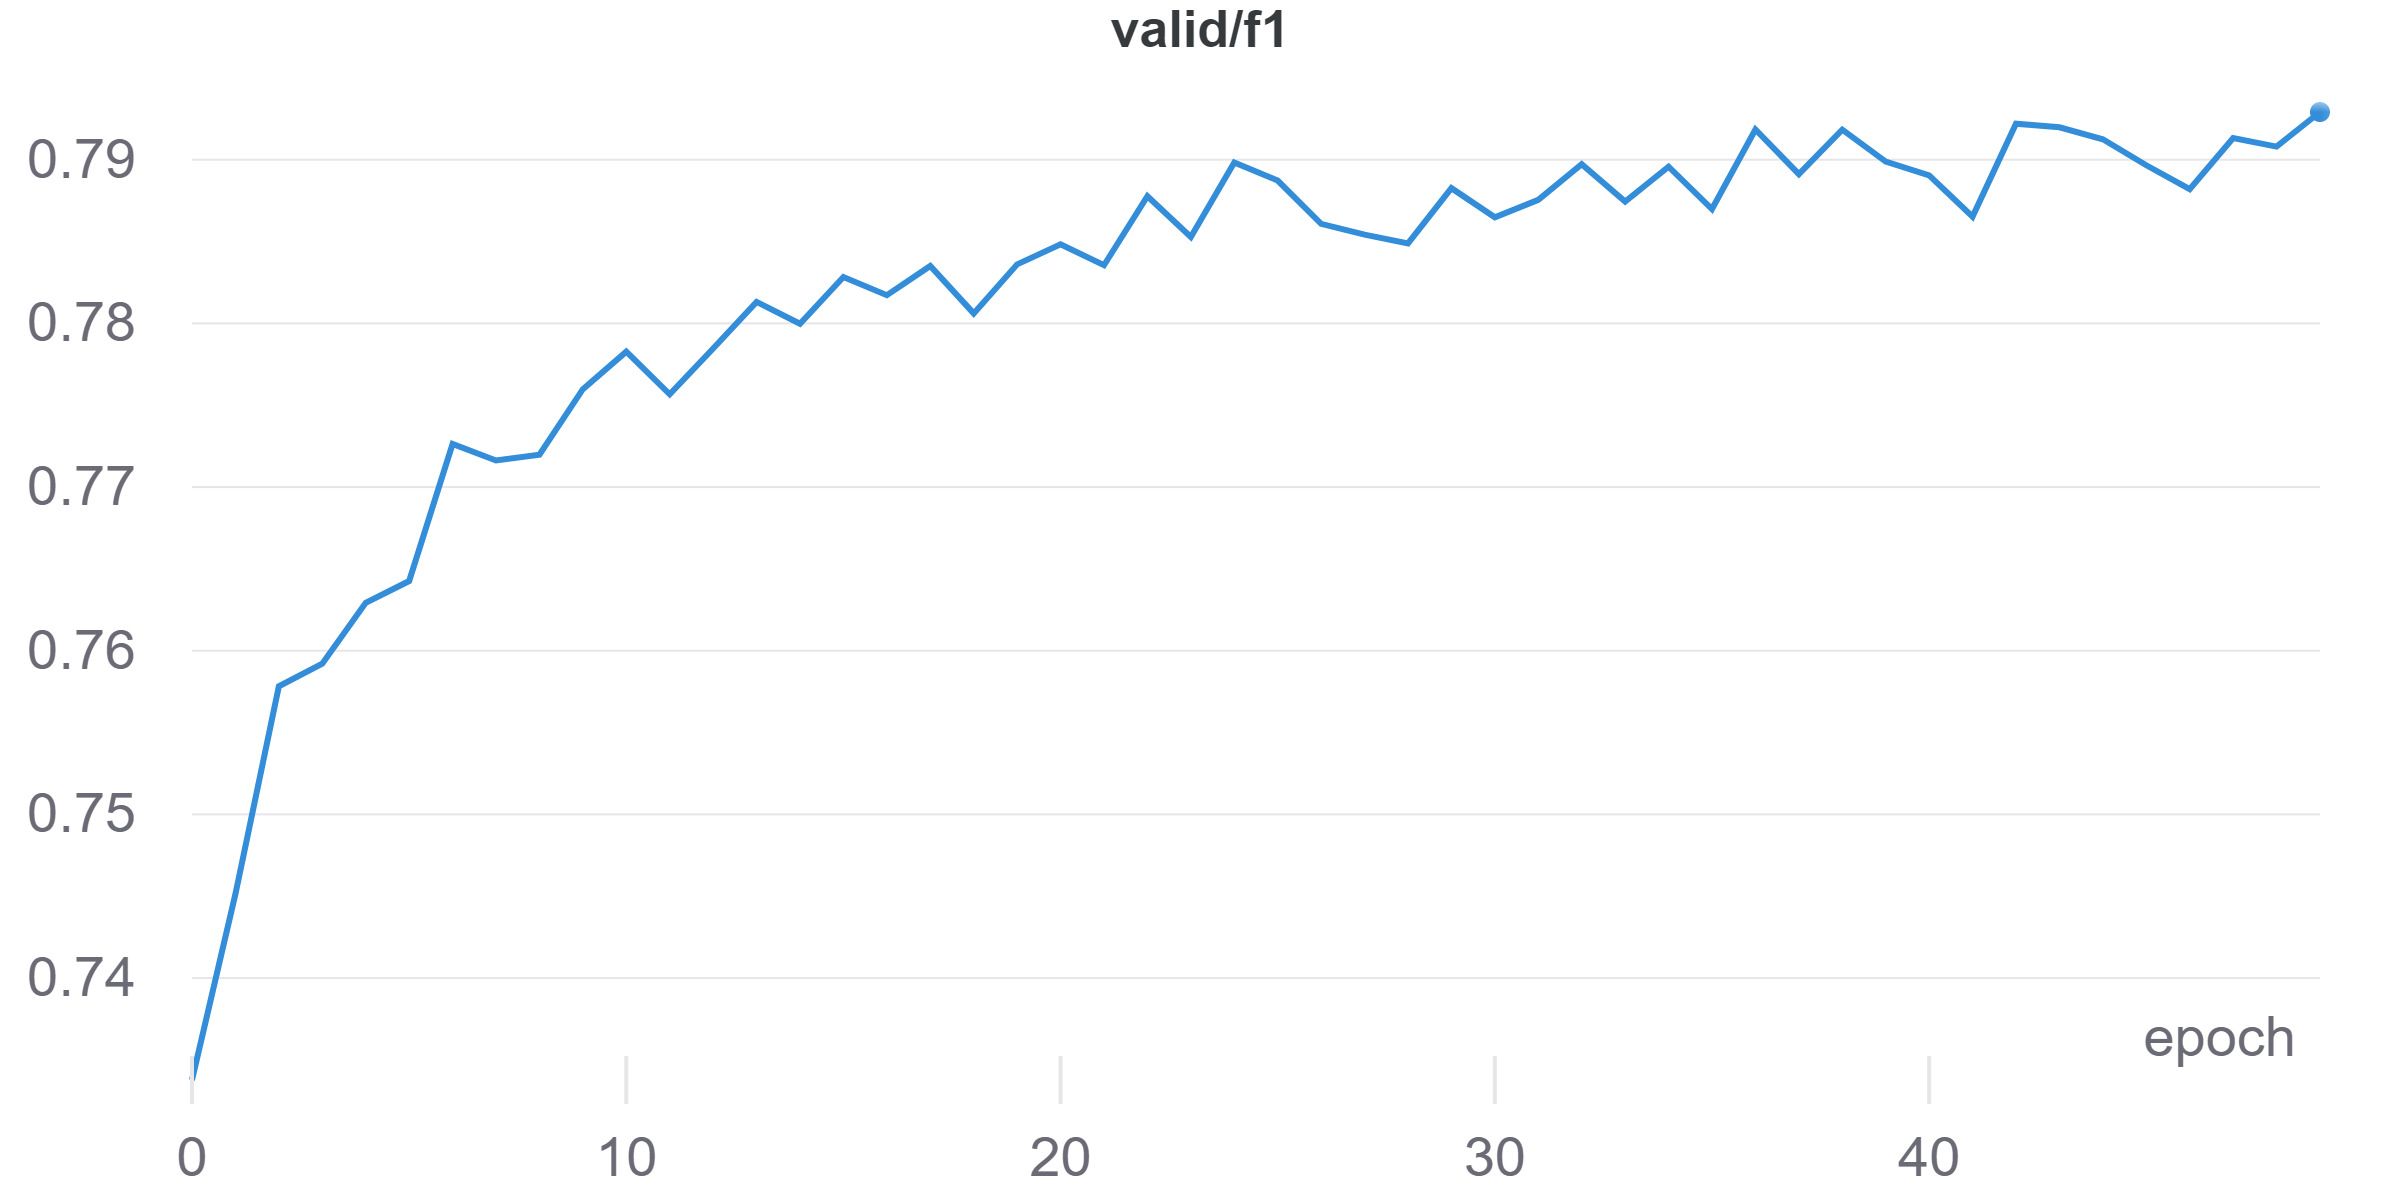

Let's see what happen when enabling cosine similarity

In [ ]:
train(optimizer='rmsprop', lr=1e-4, device=device, n_epochs=50, verbose=False, tags=['cosine similarity'],
    batch_size=512, encoder='rnn', rnn_type='gru', rnn_output='last', 
    merger='concatenation', cosine_similarity=True)

wandb_key.txt is missing. Enter here your key:··········


wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sasso (use `wandb login --relogin` to force relogin)


The vocabulary is already present. Loading it... Done!
The embedding matrix is already present. Loading it... Done!


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


STARTING TRAINING
Evaluation metrics are computed on validation set

EPOCHS | TRAIN LOSS | VALID LOSS | ACCURACY | PRECISION | RECALL |  F1   | V_ACC | V_PREC | V_REC | V_F1
[00/50]|      0.532 |      0.700 |    0.615 |     0.571 |  0.948 | 0.713 | 0.614 |  0.568 | 0.947 | 0.711
[10/50]|      0.369 |      0.524 |    0.724 |     0.661 |  0.928 | 0.772 | 0.722 |  0.658 | 0.926 | 0.769
[20/50]|      0.339 |      0.574 |    0.719 |     0.650 |  0.958 | 0.775 | 0.718 |  0.648 | 0.956 | 0.772
Validation loss increasing for 10 epochs
[30/50]|      0.316 |      0.538 |    0.740 |     0.676 |  0.929 | 0.783 | 0.739 |  0.674 | 0.926 | 0.780
Early stopping occured at epoch 36 with patience 20


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/accuracy,▁▃▅▅▅▅▄▆▆▆▆▆▆▆▆▆▅▇▅▆▇▅▆▆▇▇▇▆▇▇██▇▇▇▆▇▆▆▇
train/f1,▁▃▅▄▄▄▄▅▆▆▆▅▆▆▆▅▅▇▅▆▇▅▆▅▇▇▇▆▆▇██▇▇▇▅▇▆▆▇
train/loss,█▇▅▅▅▅▅▄▃▃▃▄▃▃▃▄▄▂▄▃▃▄▃▄▃▁▂▃▂▂▁▂▁▁▂▃▁▄▃▂
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/accuracy,▁▃▃▄▅▅▅▆▆▆▇▆▆▆▇▇█▇▇▇▇▇▇▇▇▇█▇▇▇███████
valid/f1,▁▃▄▄▅▅▆▆▆▆▇▆▇▆▇▇█▇▇▇▇▇█████▇█▇███████
valid/loss,█▆▆▅▄▃▃▃▃▃▁▃▃▄▂▂▁▂▃▂▃▄▂▂▂▂▁▃▂▂▂▂▂▁▂▃▂
valid/precision,▁▃▃▃▄▄▅▅▅▅▇▅▆▅▇▆▇▇▆▆▆▆▇▇▇▇█▆▇▇█▇██▇▇█
valid/recall,▅▅█▇█▇▇▆▆▆▂▇▆▇▃▅▂▅▆▅▆▆▄▄▆▅▁▆▅▄▂▄▃▂▃▄▁
valid/vote_accuracy,▁▃▃▄▅▅▅▆▆▆▇▆▆▆▇▇█▇▇▇▇▇▇▇▇██▇▇▇███████


FactChecker(
  (emb_layer): Embedding(403484, 100)
  (encoder): RNNEncoder(
    (output_layer): LambdaLast()
    (rec_module): GRU(100, 50, batch_first=True, bidirectional=True)
  )
  (merger): LambdaConcatenation()
  (classifier): Sequential(
    (classifier_fc1): Linear(in_features=201, out_features=100, bias=True)
    (classifier_ReLU): ReLU()
    (classifier_fc2): Linear(in_features=100, out_features=1, bias=True)
  )
)

# Final run on the testing set